# Using glikonal in a real world setting

This notebook shows how to compute the minimal altitude for safe re-entry in an airfield, for gliding flight and in presence of obstacels, such as mountains.
Throughout the notebook we will use the airfield of Montricher (LSTR) as an example. However the same procedure can be applied to any other part of the world.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import glikonal_grrp as grrp
from numba import jit
import matplotlib
import pyvista as pv

In [18]:
#the algorithm operates o a grid, with discrete indices. However we would like to use geographical coordinates to identify points on the grid. Hence we need a couple auxiliary functions to convert geographical coordinates into indices and vice versa
def coordinates_to_indices(longitude, latitude, lower_left_longitude, lower_left_latitude, upper_right_longitude,upper_right_latitude,H,W):
    """
    function to convert geographical coordinates to indices on a grid. 
    WARNING: this function will not work if the area of interest contains the 180th meridian
    """
    if(lower_left_longitude>upper_right_longitude):
        raise Exception('Right side is more east than left side')
    id_y=int((latitude-lower_left_latitude)*H/(upper_right_latitude-lower_left_latitude))
    id_x=int((longitude-lower_left_longitude)*W/(upper_right_longitude-lower_left_longitude))
    #print((longitude-lower_left_longitude)*H/(upper_right_longitude-lower_left_longitude))
    if(id_x>W or id_x<0):
        raise Exception("Index out of map bounds")
    if(id_y>H or id_y<0):
        raise Exception("Index out of map bounds")
    return id_x, id_y

def indices_to_coordinates(id_x,id_y, lower_left_longitude, lower_left_latitude, upper_right_longitude,upper_right_latitude,H,W):
    """
    Function to convert indices on a grid to geographical coordinates. 
    WARNING: this function will not work if the area of interest contains the 180th meridian.
    """
    latitude=lower_left_latitude+id_x/W*(upper_right_latitude-lower_left_latitude)
    longitude=lower_left_longitude+id_y/H*(upper_right_longitude-lower_left_longitude)
    return longitude,latitude

# Download topography data.
We will be using the free database AW3D30 created using the satellite .The database registers the elevation of points on earth every arcsecond of latitude (about 30 m) and longitude (about 30 m at the equator). For more information see 
(https://www.eorc.jaxa.jp/ALOS/en/dataset/aw3d30/aw3d30_e.htm)

The data for the surroundings of the LSTR airfield are already downloaded and they're placed in the same folder as this notebook under the name "output_AW3D30.tif". THerefore if you're only interested in this region you cqn disregard the procedure below.
1. Go to https://portal.opentopography.org/datasetMetadata?otCollectionID=OT.112016.4326.2, or go to https://opentopography.org/ search for "AW3D30" and click on the entry "ALOS World 3D - 30m".
2. In the section "Download and Access Products:" click on "AW3D30", this will open a new page
3. In the section "Coordinates" select "Manually select coordinates". This will allow us to download elevation data only for the rectangle of selected coordinates. For LSTR input the values 6,46,7,47  (in this order) in the four fields. then click "Validate coordinates and estimate area". This should show you the selected region in a map above. In the following we will refer to these four coordinted as respectively `ll_lon_tile`, `ll_lat_tile`, `ur_lon_tile`, `ur_lat_tile`, where `ll` stands for "lower left", `ur` stands for "upper right", "lat stands for "latitude" and "lon" stands for "longitude". These refer to the coordinates of the corners of the rectangle.
4. Select GeoTiff as data output format
5. Enter your email address and click on "Submit", this will send the request of the data and it will open a new page. After the process has completed download the zipped data. 
6. Unzip the data  (we will assume that the file is named "output_AW3D30.tif") and place then in the same folder as this notebook.
7. Run the next cells to load the data nito the program.

In [19]:
# Specify the file path to the DSM (Digital Surface Model) file
dsm_filename= "../elevation_data/output_AW3D30.tif"
# Open the DSM file using rasterio
with rasterio.open(dsm_filename) as src:
    # Read the DSM data as a 2D NumPy array
    dsm_data = src.read(1)
# Print the shape and data type of the DSM array
print("DSM Shape:", dsm_data.shape)
print("DSM Data Type:", dsm_data.dtype)
dsm_data=dsm_data[::-1,:]
#use lower_left upper_right convention for coordinates


DSM Shape: (3600, 3600)
DSM Data Type: int16


### Select region of interest
The data we downloaded covers a region called a "tile", however we're interested in a smaller region inside the tile. In this cell, using the variables `ll_lon_tile`, `ll_lat_tile`, `ur_lon_tile`, `ur_lat_tile` we select the rectangle on which we run the algorithm. In the case of LSTR we select a region including the airport and part of the Jura mountain chain.

In [20]:
#data about the tile
H_tile,W_tile=dsm_data.shape
#the following coordinated should be matched with the ones of the downloaded tile.
ll_lon_tile=6 #longitude of the lower left corner of the tile
ll_lat_tile=46 #latitude of the lower left corner of the tile
ur_lon_tile=7 #longitude of the upper right corner of the tile
ur_lat_tile=47 #latitude of the upper right corner of the tile

#select portion of tile to run algorithm on
#these four coordinates select the portion of tile to consider
ll_lon=6
ll_lat=46.4
ur_lon=6.6
ur_lat=46.8
id_x_ll, id_y_ll=coordinates_to_indices(longitude=ll_lon, latitude=ll_lat, lower_left_longitude=ll_lon_tile, lower_left_latitude=ll_lat_tile, upper_right_longitude=ur_lon_tile,upper_right_latitude=ur_lat_tile,H=H_tile,W=W_tile)
id_x_ur, id_y_ur=coordinates_to_indices(longitude=ur_lon, latitude=ur_lat, lower_left_longitude=ll_lon_tile, lower_left_latitude=ll_lat_tile, upper_right_longitude=ur_lon_tile,upper_right_latitude=ur_lat_tile,H=H_tile,W=W_tile)
dsm_data_cropped=dsm_data[id_y_ll:id_y_ur,id_x_ll:id_x_ur]
# W,H are respectively the number of horizontal and vertical points in the selected region.
W=id_x_ur-id_x_ll 
H=id_y_ur-id_y_ll
print(f"Selected region: longitudes:[{ll_lon}, {ur_lon}] latitudes: [{ll_lat}, {ur_lat}].")
print(f"W={W}, H={H}") 

Selected region: longitudes:[6, 6.6] latitudes: [46.4, 46.8].
W=2159, H=1440


We now compute the scale of the map ,i.e., the correspondence between spacing on the grid and meters.
The data is collected taking a measure every arcsecond. When moving N-S the spacing between points is uniform in the map and is equal to 30.83 meters.
When moving E-W the length in meters of one arcsecond changes with the latitude: it is zero at the poles and 30.922 m at the equator. At intermediate latitudes it is computed below.
We will use a uniform scale across our selected region (i.e. we will pretend all of our selected region is found at the same latitude). This will imply that we'll make a small error in computing distances when going E-W.
The magnitude of this error (in percentage) is reported below. In most cases it will be smaler than 1%.


P.S. the spacing between ponit is one arcsecond at intermediate altitudes, towards the poles the spacingg in longitude between two measurements increases. Before using the data consult documentation of the dataset at (https://www.eorc.jaxa.jp/ALOS/en/dataset/aw3d30/aw3d30_e.htm).

In [21]:
mean_latitude=(ll_lat+ur_lat)/2 #mean latitude of the map in degrees. This is used to compute the x scale of the map. The x scale is assumed to be uniform.
hx=30.922*np.cos(mean_latitude*np.pi/180) #meters corresponding to an arcsecond of longitude, at the latitude 'mean_latitude'
hy=30.83 #meters corresponding to an arcsecond of latitude

hx_max=30.922*np.cos(ll_lat*np.pi/180)
hx_min=30.922*np.cos(ur_lat*np.pi/180)
delta_h=np.maximum(np.abs(hx-hx_max),np.abs(hx-hx_min))
print(f"Maximal distance distortion from assuming uniform scale: {100*delta_h/hx:.4f}%")

x=np.linspace(0,W*hx,W)
y=np.linspace(0,H*hy,H)
xx,yy=np.meshgrid(x,y)
print(f"horizontal (E-W) spacing ={hx:.2f} m ")
print(f"vertical (N-S) spacing ={hy:.2f} m ")

Maximal distance distortion from assuming uniform scale: 0.3697%
horizontal (E-W) spacing =21.25 m 
vertical (N-S) spacing =30.83 m 


We are now ready to plot the elevation profile. 
In the case of LSTR the dark region in the bottom right is the Lac Léman, insted the brightest point in the middle is the top of Mont Tendre.

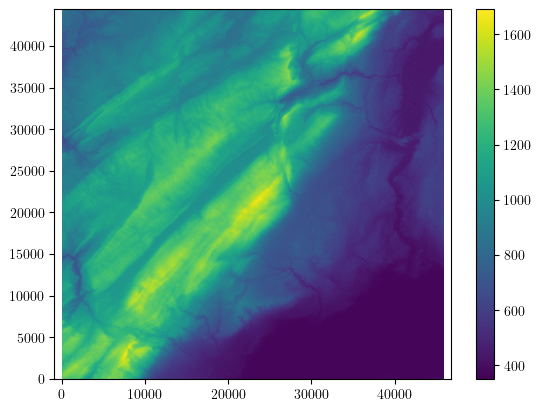

In [22]:
plt.figure()
plt.pcolormesh(xx,yy,dsm_data_cropped)
plt.axis('equal')
plt.colorbar()
#all the units are meters. Distances are measured from the bottom left corner of the tile.

In [23]:
def max_interpolate_on_square_grid(data,hx,hy,h):
    """
    Function to interpolate data on a square grid. The data is assumed to be on a regular grid, with horizontal spacing hx and vertical spacing hy. The output is a square grid of size HxW. The algorithm uses max interpolation, i.e., the value of the output grid is the maximum of the values of the input grid that are contained in the cell of the output grid.
    If the cell of the output grid contains no point of the input grid, then the value of the output grid is the value of the input grid that is closest to the center of the cell.
    
    Args:
    data: 2D numpy array of size HxW containing the data to interpolate (first index has spacing hy).
    hx: float, horizontal spacing of the input grid.
    hy: float, vertical spacing of the input grid.
    h: float, target spacing of the output grid.

    Returns:
    output: 2D numpy array of size HxW containing the interpolated data. Max interpolation.
    """
    #initialize the output
    Hold,Wold=data.shape
    H=int(hy/h*Hold)
    W=int(hx/h*Wold)

    #H=int((Hold-1)*hy/h)+1
    #W=int((Wold-1)*hx/h)+1
    output=np.zeros((H,W))
    for y in range(H):
        for x in range(W):
            #compute the coordinates of the point in the output grid
            x_out=x*h
            y_out=y*h
            #compute the coordinates of the point in the input grid
            x_in=x_out/hx
            y_in=y_out/hy
            #compute the square of size h around the point
            x_out_max=min(x_out+h/2,W*h)
            y_out_max=min(y_out+h/2,H*h)
            x_out_min=max(x_out-h/2,0)
            y_out_min=max(y_out-h/2,0)
            #check if there is at least one point in the input grid that is contained in the square
            id_x_in_max=int(np.floor(x_out_max/hx))
            id_y_in_max=int(np.floor(y_out_max/hy))
            id_x_in_min=int(np.ceil(x_out_min/hx))
            id_y_in_min=int(np.ceil(y_out_min/hy))
            #print(id_x_in_min,id_x_in_max,id_y_in_min,id_y_in_max)
            # if there is at least one point in the input grid that is contained in the square, then we compute the maximum of the values of the input grid that are contained in the square
            if(id_x_in_min<=id_x_in_max and id_y_in_min<=id_y_in_max):
                output[y,x]=data[id_y_in_min:id_y_in_max+1,id_x_in_min:id_x_in_max+1].max()
            #otherwise we set the output to the value of the input closest to the center of the square
            else:
                output[y,x]=data[round(y_in),round(x_in)]
    return output

In [24]:
h=150 #target spacing of the output grid
dsm_data_interpolated=max_interpolate_on_square_grid(dsm_data_cropped,hx,hy,h)
H,W=dsm_data_interpolated.shape
print(f"Interpolated grid: H={H}, W={W}")
hx=h
hy=h

Interpolated grid: H=295, W=305


# Aircraft gliding range
In this section we solve a different version of the previous problem. Suppose we're on an aircraft in gliding flight, initially at altitude $A$. What is the glide range of the aircraft, i.e., the set of points that the aircraft can reach before running out of altitude?

In [25]:
@jit(nopython=True)
def glide_ratio(a,wind):
    base_glide_ratio=20
    k=np.linalg.norm(wind) #ratio between the wind speed and the airspeed of the aircraft. gamma should be (1+k)/(1-k)
    return base_glide_ratio*(np.sqrt(1-k**2+k**2*np.sum(a*wind)**2)+k*np.sum(a*wind))

In [26]:
minimal_enroute_height=200
initial_altitude=2070
#coordinates for Lac du Joux, in front of l'Abbaye: 6.312692 E, 46.650790 N. Re entry through Mollendruz at 1650m with 200m enroute minimal height.

#coordinates for Le Brassus; 6.20050 E, 46.580040 N. Re entry through  Marchairuz at 1900m with 200m enroute minimal height. Re entry through Marchairuz and reach the Lac Léman at 2000m with 200m enroute minimal height.
#coordinates for center of Lac du Joux (slightly SW of the center of the lake): 6.273666 E, 46.631861 N. Re entry through either Mollendruz or Marchairuz at 1900m with 200m enroute minimal height.
#coordinates for SW end of the Lac du Joux 46.607689 N, 6.237373 E (more ). Re entry through Mollendruz or Marchairuz at 1900m with 200m enroute minimal height.

#Le lieu 46.629817, 6.248679,    46.645309, 6.233155

aircraft_lon= 6.213666#6.233155#6.265876#6.237373#6.273666#6.312692#
aircraft_lat=  46.611861 # 46.645309#46.613270#46.607689#46.631861#46.650790#

#to show airfield on map 
airfield_lon=6.40050
airfield_lat=46.59540

aircraft_id_x,aircraft_id_y=coordinates_to_indices(aircraft_lon, aircraft_lat, lower_left_longitude=ll_lon, lower_left_latitude=ll_lat, upper_right_longitude=ur_lon,upper_right_latitude=ur_lat,H=H,W=W)
airfield_id_x,airfield_id_y=coordinates_to_indices(airfield_lon, airfield_lat, lower_left_longitude=ll_lon, lower_left_latitude=ll_lat, upper_right_longitude=ur_lon,upper_right_latitude=ur_lat,H=H,W=W)

elevation_corr=dsm_data_interpolated+minimal_enroute_height
print(f"enroute minimal height= {minimal_enroute_height} m. (at all points the gliding trajectory must be at least {minimal_enroute_height} m above the terrain)")

#define the wind field
Z=20 #number of layers in the wind field
hz=150 #height of each layer in meters
wind_angles=np.ones([H,W,Z])*7./6*np.pi #np.random.uniform(0,2*np.pi,size=[H,W]) #with respect to the y axis, positive towards east (clockwise)
wind_field=np.zeros([H,W,Z,2])
wind_strength=0.3*np.ones([H,W,Z])
wind_field[...,0]=wind_strength*np.cos(wind_angles)
wind_field[...,1]=wind_strength*np.sin(wind_angles)

for z in range(Z):
    alt=z*hz
    mult=alt/2000
    if(mult>1):
        mult=1
    elif(mult<0.333):
        mult=0.333
    wind_field[:,:,z,:]=wind_field[:,:,z,:]*mult

    #plt.figure()
    #plt.pcolormesh(xx,yy,wind_strength[:,:,z])
    #plt.axis('equal')
    #plt.colorbar()
    #plt.title(f"Wind strength at height {z*hz} m")
    #plt.show()
    #plt.figure()
    #plt.quiver(xx,yy,wind_field[:,:,z,0],wind_field[:,:,z,1])
    #plt.axis('equal')
    #plt.title(f"Wind field at height {z*hz} m")
    #plt.show()
wind=wind_field[aircraft_id_y,aircraft_id_x,np.round(initial_altitude/hz).astype(int)]
Gamma=(1+np.max(wind_strength))/(1-np.max(wind_strength))

enroute minimal height= 200 m. (at all points the gliding trajectory must be at least 200 m above the terrain)


In [27]:
radius=300#meters
init_pos=(aircraft_id_y,aircraft_id_x)
init_nodes,init_values,init_chars=grrp.point_source_HJB_uniform_solver(init_pos,initial_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
grid,grid_chars=grrp.OUM_GRRP(velocity_func=glide_ratio,Gamma=Gamma,elevation=elevation_corr,init_nodes=init_nodes,init_altitudes=init_values,init_chars=init_chars, hy=hy,hx=hx,hz=hz,H=H,W=W,wind_field=wind_field)
grid=np.maximum(grid,np.zeros_like(grid))
grid[grid==0]=np.inf

In [28]:
grid2=np.copy(grid)
grid2[grid2==np.inf]=0
grid2[grid2>0]=np.inf
grid2[0,0]=1

In [29]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(1-c,0,0,1) for c in np.linspace(0,1,100)]# Create the colormap
cmap_name = 'red_to_black'
n_bins = 100  # Number of bins (discrete color levels)
cmap_red = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_25933/3107115625.py:13: UserWarning: The following kwargs were not used by contour: 'label'
  CS=ax.contour(X,Y,grid,colors='k',label='aircraft',linewidths=0.8)


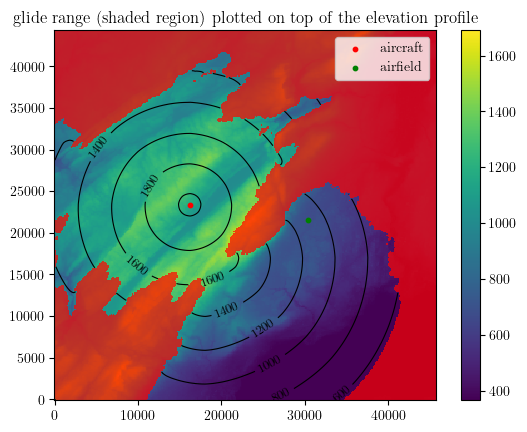

In [30]:
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
fig,ax=plt.subplots()

pc=ax.pcolormesh(X,Y,dsm_data_interpolated,cmap='viridis',shading='nearest')
cmap=plt.get_cmap('binary')
#cmap.set_under(color=(0,0,0), alpha=0)

pc2=ax.pcolormesh(X,Y,grid2,cmap=cmap_red,shading='nearest',alpha=0.7)

plt.scatter(aircraft_id_x*hx,aircraft_id_y*hy,c="red",label="aircraft",s=10,zorder=1000)
plt.scatter(airfield_id_x*hx,airfield_id_y*hy,c="green",label="airfield",s=10,zorder=1000)
fig.colorbar(pc)
CS=ax.contour(X,Y,grid,colors='k',label='aircraft',linewidths=0.8)
ax.clabel(CS, fontsize=9, inline=True)

ax.set_aspect('equal')
ax.set_title('glide range (shaded region) plotted on top of the elevation profile')
ax.legend()

/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_25933/3874634011.py:50: UserWarning: The following kwargs were not used by contour: 'label'
  CS=ax.contour(X,Y,grid,colors='black',label='aircraft',linewidths=0.7)


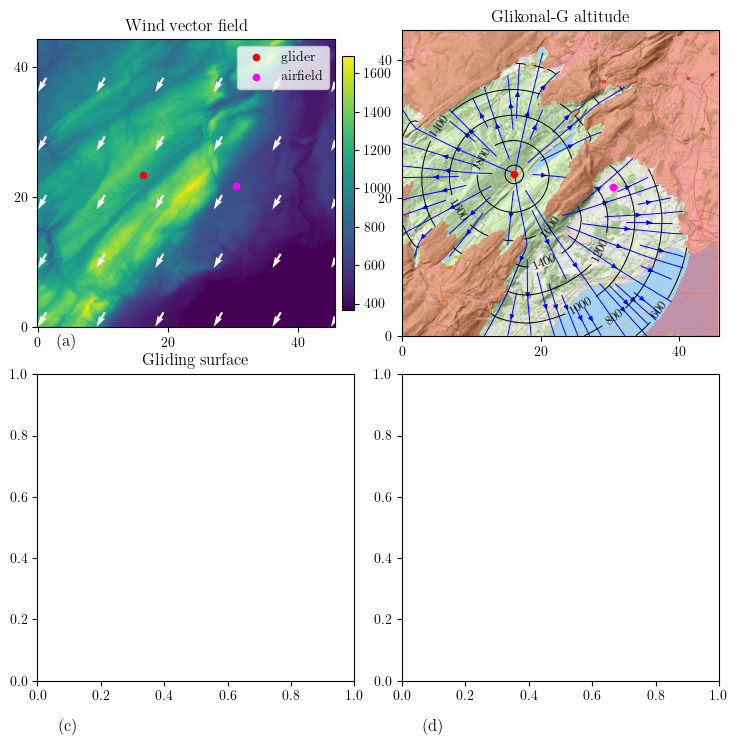

In [32]:

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True})

fig,axes=plt.subplots(2,2,figsize=(7.4,7))

fig.tight_layout(pad=0.8)

resc=1000
ax=axes[0,0]
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
X=X/resc
Y=Y/resc
U=np.moveaxis(wind_field[...,-1,1],0,1)
V=np.moveaxis(wind_field[...,-1,0],0,1)
xx,yy=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H),indexing='ij')
xx=xx/resc
yy=yy/resc
#pc=ax.pcolormesh(X,Y,dsm_data_interpolated,cmap='terrain',shading='nearest',vmin=-40,vmax=2000)
pc=ax.pcolormesh(X,Y,dsm_data_interpolated,cmap='viridis',shading='nearest')

fig.colorbar(pc,ax=ax,fraction=0.04, pad=0.02)
Nx=60
Ny=60

q = ax.quiver(xx[::Nx,::Ny], yy[::Nx,::Ny], U[::Nx,::Ny], V[::Nx,::Ny],color='white',pivot='tip')
#ax.quiverkey(q, X=0.3, Y=1.1, U=10,label='.')
ax.set_aspect('equal')
ax.set_xticks([0,20,40])
ax.set_yticks([0,20,40])
ax.set_title('Wind vector field')
ax.text(0.1, -0.05, "(a)", ha='center', va='center', transform=ax.transAxes, fontsize=12)
ax.scatter([init_pos[1]*hx/resc],[init_pos[0]*hy/resc],color='r',label='glider',zorder=10000,s=20)
ax.scatter([airfield_id_x*hx/resc],[airfield_id_y*hy/resc],color='magenta',label='airfield',zorder=10000,s=20)
ax.legend()

ax=axes[0,1]

#pc2=ax.pcolormesh(X,Y,dsm_data_interpolated,cmap='viridis',shading='nearest')
img = matplotlib.image.imread('../elevation_data/6_6.6E_46.4_46.8N_tile_topo.png')
extent=[0,hx*W/resc,0,hy*H/resc]
ax.imshow(img, extent=extent)
#pc2=ax.pcolormesh(X,Y,grid>0,cmap='binary',shading='nearest',alpha=0.1)
ax.streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=0.94,color='blue',linewidth=0.7,arrowsize=0.7)

CS=ax.contour(X,Y,grid,colors='black',label='aircraft',linewidths=0.7)
ax.scatter([init_pos[1]*hx/resc],[init_pos[0]*hy/resc],color='r',label='glider',zorder=10000,s=20)
ax.scatter([airfield_id_x*hx/resc],[airfield_id_y*hy/resc],color='magenta',label='airfield',zorder=10000,s=20)

#fig.colorbar(pc,ax=ax,fraction=0.044, pad=0.02)

grid2[grid2==-np.inf]=0
grid2[grid2>0]=np.inf
grid2[0,0]=1

colors = [(1-c,0,0,1) for c in np.linspace(0,1,100)]# Create the colormap
cmap_name = 'red_to_black'
n_bins = 100  # Number of bins (discrete color levels)
cmap_red = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
pc2=ax.pcolormesh(X,Y,grid2,cmap=cmap_red,shading='nearest',alpha=0.3)
ax.clabel(CS, fontsize=9, inline=True)
ax.set_aspect('equal')
ax.set_xticks([0,20,40])
ax.set_yticks([0,20,40])
#ax.set_xlim([0,100])
ax.set_title('Glikonal-G altitude')
ax.text(0.1, -0.15, "(b)", ha='center', va='center', transform=ax.transAxes, fontsize=12)
ax=axes[1,0]

ax.set_title("Gliding surface")
ax.text(0.1, -0.15, "(c)", ha='center', va='center', transform=ax.transAxes, fontsize=12)
ax=axes[1,1]
ax.text(0.1, -0.15, "(d)", ha='center', va='center', transform=ax.transAxes, fontsize=12)
plt.savefig("pics/glikonal_grrp_lstr_2070.pdf", bbox_inches='tight', dpi=600)

In [33]:

grid=np.maximum(grid,np.zeros_like(grid))
grid[grid==np.inf]=np.nan
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
rescale_z=8
# Create the first surface
surf1 = pv.StructuredGrid(X, Y, rescale_z*dsm_data_interpolated)
surf1['elevation'] = rescale_z*dsm_data_interpolated.T.flatten()

# Create the second surface
surf2 = pv.StructuredGrid(X, Y, rescale_z*grid)
surf2_shift = pv.StructuredGrid(X, Y, rescale_z*(grid+0.1))# perturbing to avoid overlapping surfaces (visual artifacts)

surf2['elevation'] = grid.T.flatten()
surf2_shift['elevation'] = (grid).T.flatten()


point=[hx*init_pos[1],hy*init_pos[0],rescale_z*initial_altitude]
point2=[airfield_id_x*hx,airfield_id_y*hy,rescale_z*670]

point_cloud = pv.PolyData(point)
point_cloud2 = pv.PolyData(point2)
start_line_airfield = np.array([airfield_id_x*hx, airfield_id_y*hy, 670*rescale_z])
end_line_airfield = np.array([airfield_id_x*hx, airfield_id_y*hy,1400*rescale_z])
airfield_line = pv.Line(start_line_airfield, end_line_airfield)
contours_alt = surf2_shift.contour()

# Plot the surfaces
plotter = pv.Plotter()
plotter.enable_anti_aliasing('msaa', multi_samples=16)

plotter.add_mesh(surf2, color='orange',cmap='viridis', opacity=0.6)
plotter.add_mesh(surf1, opacity=1, cmap='viridis', show_scalar_bar=False)
plotter.add_mesh(contours_alt, color="white", line_width=3)
plotter.add_mesh(point_cloud, color='red', point_size=10)
plotter.add_mesh(point_cloud2, color='magenta', point_size=10)
plotter.add_mesh(airfield_line, color='magenta', line_width=3)

# Show the plot
plotter.show()
plotter.save_graphic("pics/glikonal_grrp_lstr_2070_3d.pdf",raster=False)

/Users/piccioli/opt/anaconda3/envs/torch/lib/python3.8/site-packages/pyvista/core/utilities/points.py:52: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value='<iframe src="http://localhost:65446/index.html?ui=P_0x7fd19baed910_1&reconnect=auto" class="pyvi…